# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import json

import xgboost as xgb

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pmdarima import auto_arima
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '\config-example.json', 'r') as f:
    config = json.load(f)

dataset_audited_fname = config['DEFAULT']['dataset_audited_fname']
processing_path = config['DEFAULT']['processing_path']
dataset_fname_suffix = config['DEFAULT']['dataset_fname_suffix']

In [17]:
client_data = pd.read_csv(os.path.join(processing_path,dataset_audited_fname) + dataset_fname_suffix, header = 0, delimiter = ',',)

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_17200\1252656687.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  client_data = pd.read_csv(os.path.join(processing_path,dataset_audited_fname) + dataset_fname_suffix, header = 0, delimiter = ',',)


In [18]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658446 entries, 0 to 658445
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   EventName          658446 non-null  object 
 1   StartDate          658446 non-null  object 
 2   EventType          658446 non-null  object 
 3   BookingReference   658446 non-null  object 
 4   AttendeeReference  658446 non-null  object 
 5   GroupSize          658446 non-null  int64  
 6   IsLeadAttendee     658446 non-null  object 
 7   AttendeeGrossCost  658446 non-null  float64
 8   EventId            658446 non-null  int64  
 9   BookingStatus      658446 non-null  object 
 10  AttendeeType       658446 non-null  object 
 11  StatusCreatedDate  658444 non-null  object 
 12  ClientId           658446 non-null  float64
 13  StartYear          658446 non-null  int64  
 14  StatusCreatedYear  658444 non-null  float64
dtypes: float64(3), int64(3), object(9)
memory usage: 75

In [6]:
client_data.head(3)

,EventName,StartDate,EventType,BookingReference,AttendeeReference,GroupSize,IsLeadAttendee,AttendeeGrossCost,EventId,BookingStatus,AttendeeType,StatusCreatedDate,ClientId,StartYear,StatusCreatedYear
0,Developing Reading and Writing Skills,2017-11-28 00:00:00,"Others, Group 1",B462687,A514297,1,True,0.0,14983,Attending,Attendee,2017-11-11 09:15:00,153.0,2017,2017.0
1,Teaching Grammar: Classroom choices,2017-12-13 00:00:00,"Others, Group 1",B462689,A514299,1,True,0.0,14960,Attending,Attendee,2017-11-11 09:18:00,153.0,2017,2017.0
2,Teaching Grammar: Classroom choices,2017-12-13 00:00:00,"Others, Group 1",B467150,A519135,1,True,0.0,14960,Attending,Attendee,2017-11-22 17:02:00,153.0,2017,2017.0


In [19]:
client_data['StatusCreatedDate'] = client_data['StatusCreatedDate'].fillna(method='ffill')              # filling status created data (forgot to fill in sampling file)

In [20]:
client_data['StartDate'] = pd.to_datetime(client_data['StartDate'], infer_datetime_format=True)
client_data['StatusCreatedDate'] = pd.to_datetime(client_data['StatusCreatedDate'], infer_datetime_format=True)

In [21]:
# Creating the Season column
_condition_winter = (client_data.StartDate.dt.month>=1)&(client_data.StartDate.dt.month<=3)
_condtion_spring = (client_data.StartDate.dt.month>=4)&(client_data.StartDate.dt.month<=6)
_condition_summer = (client_data.StartDate.dt.month>=7)&(client_data.StartDate.dt.month<=9)
_condition_autumn = (client_data.StartDate.dt.month>=10)&(client_data.StartDate.dt.month<=12)
client_data['Season'] = np.where(_condition_winter,'Winter',np.where(_condtion_spring,'Spring',np.where(_condition_summer,'Summer',np.where(_condition_autumn,'Autumn',np.nan))))

In [22]:
# Creating Days to Event
client_data['Days to Event'] = (client_data['StartDate'] - client_data['StatusCreatedDate']).dt.days 

In [23]:
client_data.head(3)

,EventName,StartDate,EventType,BookingReference,AttendeeReference,GroupSize,IsLeadAttendee,AttendeeGrossCost,EventId,BookingStatus,AttendeeType,StatusCreatedDate,ClientId,StartYear,StatusCreatedYear,Season,Days to Event
0,Developing Reading and Writing Skills,2017-11-28,"Others, Group 1",B462687,A514297,1,True,0.0,14983,Attending,Attendee,2017-11-11 09:15:00,153.0,2017,2017.0,Autumn,16
1,Teaching Grammar: Classroom choices,2017-12-13,"Others, Group 1",B462689,A514299,1,True,0.0,14960,Attending,Attendee,2017-11-11 09:18:00,153.0,2017,2017.0,Autumn,31
2,Teaching Grammar: Classroom choices,2017-12-13,"Others, Group 1",B467150,A519135,1,True,0.0,14960,Attending,Attendee,2017-11-22 17:02:00,153.0,2017,2017.0,Autumn,20


In [24]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658446 entries, 0 to 658445
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   EventName          658446 non-null  object        
 1   StartDate          658446 non-null  datetime64[ns]
 2   EventType          658446 non-null  object        
 3   BookingReference   658446 non-null  object        
 4   AttendeeReference  658446 non-null  object        
 5   GroupSize          658446 non-null  int64         
 6   IsLeadAttendee     658446 non-null  object        
 7   AttendeeGrossCost  658446 non-null  float64       
 8   EventId            658446 non-null  int64         
 9   BookingStatus      658446 non-null  object        
 10  AttendeeType       658446 non-null  object        
 11  StatusCreatedDate  658446 non-null  datetime64[ns]
 12  ClientId           658446 non-null  float64       
 13  StartYear          658446 non-null  int64   

In [25]:
# Using drop() to delete row based with '#NUM!'

client_data.drop(client_data[client_data['Days to Event'] < 0].index, inplace=True)

In [26]:
# Creating weeks to Event
client_data['Weeks to Event'] = client_data['Days to Event'].div(7).round(0)

In [27]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474976 entries, 0 to 658353
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   EventName          474976 non-null  object        
 1   StartDate          474976 non-null  datetime64[ns]
 2   EventType          474976 non-null  object        
 3   BookingReference   474976 non-null  object        
 4   AttendeeReference  474976 non-null  object        
 5   GroupSize          474976 non-null  int64         
 6   IsLeadAttendee     474976 non-null  object        
 7   AttendeeGrossCost  474976 non-null  float64       
 8   EventId            474976 non-null  int64         
 9   BookingStatus      474976 non-null  object        
 10  AttendeeType       474976 non-null  object        
 11  StatusCreatedDate  474976 non-null  datetime64[ns]
 12  ClientId           474976 non-null  float64       
 13  StartYear          474976 non-null  int64   

In [28]:
client_data['Days to Event'].isnull().sum()

0

In [29]:
# Dropping rows with "Cancelled" in event name column
client_data.drop(client_data[~client_data["EventName"].str.contains('CANCELLED')==False].index, inplace=True)
# Dropping rows with "Cancelled" in BookingStatus column
client_data.drop(client_data[client_data["BookingStatus"] == "Cancelled"].index, inplace= True)

In [30]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472592 entries, 0 to 658353
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   EventName          472592 non-null  object        
 1   StartDate          472592 non-null  datetime64[ns]
 2   EventType          472592 non-null  object        
 3   BookingReference   472592 non-null  object        
 4   AttendeeReference  472592 non-null  object        
 5   GroupSize          472592 non-null  int64         
 6   IsLeadAttendee     472592 non-null  object        
 7   AttendeeGrossCost  472592 non-null  float64       
 8   EventId            472592 non-null  int64         
 9   BookingStatus      472592 non-null  object        
 10  AttendeeType       472592 non-null  object        
 11  StatusCreatedDate  472592 non-null  datetime64[ns]
 12  ClientId           472592 non-null  float64       
 13  StartYear          472592 non-null  int64   

In [276]:
# Creating Days to Event
# data['Sell Out Time'] = (data['StartDate'] - data['StatusCreatedDate']).dt.days 

## Thoughts

Questions?
1. If I am to host an event, when can I start panicking that I may not sell enough tickets?
2. When can I start panicking that I may eventually sell more tickets than planned ?
3. When can I tell my client to change their venue to a smaller or bigger place?
4. How long can I tell my client to leave their sales open for to get their maximum number of sales without doing anything? This is coupled with the seasons of when ticket sales starts maybe.

3 things Gerald wants to see.
1.	How long to sell out tickets irrespective of your event 
2.	The approximate number of tickets it will sell.
3.	Give me a distribution of the number of tickets. 

2 & 3 answered the same


# Question 1

How long to sell out tickets irrespective of your event ?

# ARIMA Model
Use an ARIMA model to predict the Sell Out Period (Days) and number of bookings (BookingReference). Consider 30 percent of
data for testing. 

In [277]:
# Set the StartDate as index
data1 =data1.set_index('StartDate')

NameError: name 'data1' is not defined

### Encoding Categorical Varibles
When training a machine learning model, all categorical variables must be convert into numeric form. Here, the `LabelEncoder` is used.

In [ ]:
# Get all categorical variales
categorical_col = data1.columns[data1.dtypes == "object"].to_list()
categorical_col

['Season', 'EventType']

In [ ]:
LE = LabelEncoder()

for col in categorical_col:
    # Transoform to numeric form
    data1[col] = LE.fit_transform(data1[col])

In [ ]:
data1.head(3)

,Season,EventType,Weeks to Event,Sell Out Period (Days)
StartDate,,,,
2021-10-09 13:00:00,0,7,12.0,0
2021-10-11 11:00:00,0,7,0.0,0
2021-10-11 11:00:00,0,7,1.0,0


### Normalizing the Dataset

The different features in the dataset are on diffeberent scales of values. It's always best practice to scale all features to be on the same range of values so as to help the machine learning algorithm do better during training. Here, we use the `StandardScaler` to normalize all features to have values between -1 and +1.

In [ ]:
cols_to_normalize = ['Season', 'EventType', 'Weeks to Event', 'Sell Out Period (Days)']

# Instantiate the standard scaler
sc = StandardScaler()

for col in cols_to_normalize:
    data1[col] = sc.fit_transform(data1[[col]])

Use an ARIMA model to predict the weekly average demand rate. Consider 30 percent of
data for testing. 

In [ ]:
# Check if dataset is stationary
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(data1['Purchase_Period'])

1. ADF :  -11.749958258578195
2. P-Value :  1.215831000636473e-21
3. Num Of Lags :  29
4. Num Of Observations Used For ADF Regression: 8519
5. Critical Values :
	 1% :  -3.4311178449951383
	 5% :  -2.861879335316165
	 10% :  -2.5669506232813166


In [ ]:
# using auto arima to predict best p, d, q values
stepwise_fit = auto_arima(data1['Purchase_Period'], trace=True,
                         suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32574.061, Time=5.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36215.096, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35171.023, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33267.242, Time=2.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36213.096, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32566.773, Time=4.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32593.760, Time=2.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32570.085, Time=2.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=32585.540, Time=3.80 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=32567.901, Time=3.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32567.240, Time=3.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=32567.369, Time=10.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=32564.911, Time=1.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32591.861, Time=0.79 sec
 ARIMA(1,1,1)(0,0,

In [ ]:
# Split dataset 
split_size = int(0.7*len(data1))

train_data1 = data1.iloc[:split_size, :]
test_data1 = data1.iloc[split_size:, :]

In [ ]:
# Fit ARIMA model on best p, d, q values
model = sm.tsa.arima.ARIMA(train_data1["Purchase_Period"], order=(1,1,2))
arima_model = model.fit()

c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_d

In [ ]:
start_index = len(train_data1)
stop_index = len(train_data1) + len(test_data1)-1

# prediction on test length
pred = arima_model.predict(start=start_index, end=stop_index)
pred.index=data1.index[start_index:stop_index+1]
print(pred)



StartDate
2021-08-12 15:30:00    1.042994
2021-08-12 15:30:00    0.707671
2021-08-12 15:30:00    0.629363
2021-08-12 15:30:00    0.611076
2021-08-12 17:15:00    0.606805
                         ...   
2022-01-02 18:00:00    0.605504
2022-01-02 18:30:00    0.605504
2022-01-02 18:30:00    0.605504
2022-01-02 18:30:00    0.605504
2022-01-02 18:30:00    0.605504
Name: predicted_mean, Length: 2565, dtype: float64


c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:xlabel='StartDate'>

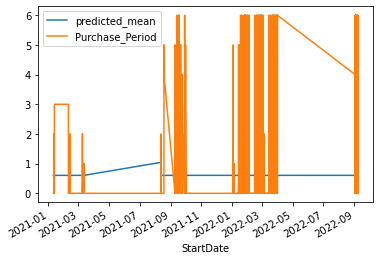

In [ ]:
pred.plot(legend=True)
test_data1['Purchase_Period'].plot(legend=True)

In [ ]:
data1['Purchase_Period'].mean()

1.0047885888945491

In [ ]:
mse = mean_squared_error(test_data1["Purchase_Period"], pred)

print(f"Mean Squared Error for ARIMA model is {round(mse, 3)}")

# print("prediction on weekly average of demand rate")
# pred[:6]

Mean Squared Error for ARIMA model is 3.802


Use an ARIMA model to predict the weekly average demand rate. Consider 30 percent of
data for testing. 

In [ ]:
# Set the StartDate as index
data2 =data2.set_index('StartDate')

In [ ]:
# Check if dataset is stationary
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(data2['BookingReference'])

1. ADF :  -27.189090154155366
2. P-Value :  0.0
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression: 8540
5. Critical Values :
	 1% :  -3.4311159562837132
	 5% :  -2.861878500741634
	 10% :  -2.566950179030763


In [ ]:
# using auto arima to predict best p, d, q values
stepwise_fit = auto_arima(data2['BookingReference'], trace=True,
                         suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70033.071, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68826.879, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=66741.919, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70031.071, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.95 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=66739.920, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=1.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=68824.879, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=1.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 26.454 seconds


In [ ]:
# Split dataset 
split_size = int(0.7*len(data2))

train_data2 = data2.iloc[:split_size, :]
test_data2 = data2.iloc[split_size:, :]

In [ ]:
# Fit ARIMA model on best p, d, q values
model = sm.tsa.arima.ARIMA(train_data2["BookingReference"], order=(0,1,1))
arima_model = model.fit()

c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_d

In [ ]:
start_index = len(train_data2)
stop_index = len(train_data2) + len(test_data2)-1

# prediction on test length
pred = arima_model.predict(start=start_index, end=stop_index)
pred.index=data2.index[start_index:stop_index+1]
print(pred)


c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


StartDate
2021-08-12 15:30:00    6.023797
2021-08-12 15:30:00    6.023797
2021-08-12 15:30:00    6.023797
2021-08-12 15:30:00    6.023797
2021-08-12 17:15:00    6.023797
                         ...   
2022-01-02 18:00:00    6.023797
2022-01-02 18:30:00    6.023797
2022-01-02 18:30:00    6.023797
2022-01-02 18:30:00    6.023797
2022-01-02 18:30:00    6.023797
Name: predicted_mean, Length: 2565, dtype: float64


<AxesSubplot:xlabel='StartDate'>

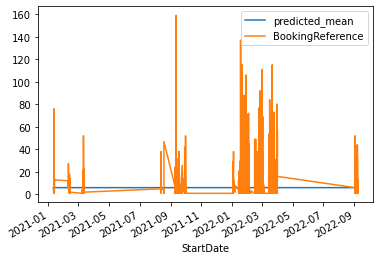

In [ ]:
pred.plot(legend=True)
test_data2['BookingReference'].plot(legend=True)

In [ ]:
mse = mean_squared_error(test_data2["BookingReference"], pred)

print(f"Mean Squared Error for ARIMA model is {round(mse, 3)}")

# print("prediction on weekly average of demand rate")
# pred[:6]

Mean Squared Error for ARIMA model is 193.322


# XGBoost

In [ ]:
data0 = data.groupby(['Season','StartDate','EventId','EventType'], as_index=False).agg(
                                                                                            Min_Purchase_Week_Date = pd.NamedAgg(column='StatusCreatedDate', aggfunc='min'),
                                                                                            Max_Purchase_Week_Date = pd.NamedAgg(column='StatusCreatedDate', aggfunc='max'),  
                                                                                            Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                            )
data0['Max_Week'] = data0['Max_Purchase_Week_Date'].dt.week
data0['Min_Week'] = data0['Min_Purchase_Week_Date'].dt.week
data0['Purchase_Period_Week'] = (data0['Max_Week'] - data0['Min_Week']).abs()
data0                                                                                          

#### What is the purchase period for each event to the start date ?

In [847]:
data_week_purchase_period = data.groupby(['StartDate','Season','EventId'], as_index=False).agg(
                                                                                            Min_Purchase_Week_Date = pd.NamedAgg(column='Weeks to Event', aggfunc='min'),
                                                                                            Max_Purchase_Week_Date = pd.NamedAgg(column='Weeks to Event', aggfunc='max'),  
                                                                                            Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                            )

# data_week_purchase_period['Max_Week'] = data_week_purchase_period['Max_Purchase_Week_Date'].dt.week
# data_week_purchase_period['Min_Week'] = data_week_purchase_period['Min_Purchase_Week_Date'].dt.week
data_week_purchase_period['Purchase_Period_Week'] = (data_week_purchase_period['Min_Purchase_Week_Date'] - data_week_purchase_period['Max_Purchase_Week_Date']).abs()
data_week_purchase_period



,StartDate,Season,EventId,Min_Purchase_Week_Date,Max_Purchase_Week_Date,Num_of_ticket,Purchase_Period_Week
0,2021-01-10 17:00:00,Winter,24964,0.0,0.0,5,0.0
1,2021-01-11 15:00:00,Winter,24694,0.0,0.0,1,0.0
2,2021-01-11 17:00:00,Winter,24669,0.0,0.0,7,0.0
3,2021-01-11 17:15:00,Winter,24641,0.0,0.0,63,0.0
4,2021-01-11 17:15:00,Winter,24911,0.0,0.0,1,0.0
...,...,...,...,...,...,...,...
1336,2022-12-05 17:30:00,Autumn,25970,0.0,48.0,122,48.0
1337,2022-12-05 17:30:00,Autumn,26095,0.0,43.0,27,43.0
1338,2022-12-05 17:30:00,Autumn,26225,0.0,39.0,11,39.0
1339,2022-12-05 17:45:00,Autumn,24692,0.0,59.0,46,59.0


### Weekly Sales

In [910]:
data_weekly_ticket_sales = data.groupby(['EventId','StatusCreatedDate','StartDate','Weeks to Event'], as_index=False).agg(Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                                                                                )
data_weekly_ticket_sales

# data_weekly_ticket_sales = data.groupby(['StatusCreatedDate','StatusCreatedWeek','Season','EventType'], as_index=False).agg(
                                                                                            # Min_Purchase_Day = pd.NamedAgg(column='StatusCreatedDate', aggfunc='min'),
                                                                                            # Max_Purchase_Day = pd.NamedAgg(column='StatusCreatedDate', aggfunc='max'),  
                                                                                            # Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                            # )
# data_weekly_ticket_sales['Purchase_Period'] = (data_weekly_ticket_sales['Max_Purchase_Day'] - data_weekly_ticket_sales['Min_Purchase_Day']).dt.days
# data_weekly_ticket_sales)

,EventId,StatusCreatedDate,StartDate,Weeks to Event,Num_of_ticket
0,22520,2021-01-11 12:29:00,2021-02-12 13:00:00,5.0,1
1,22520,2021-01-11 15:59:00,2021-02-12 13:00:00,4.0,1
2,24071,2021-01-10 05:03:00,2021-10-22 15:00:00,41.0,1
3,24071,2021-01-10 05:07:00,2021-10-22 15:00:00,41.0,1
4,24071,2021-01-10 05:57:00,2021-10-22 15:00:00,41.0,1
...,...,...,...,...,...
59715,26430,2022-06-29 14:47:00,2022-07-14 10:00:00,2.0,1
59716,26430,2022-06-29 14:50:00,2022-07-14 10:00:00,2.0,1
59717,26430,2022-06-29 14:54:00,2022-07-14 10:00:00,2.0,1
59718,26430,2022-06-29 16:25:00,2022-07-14 10:00:00,2.0,1


In [909]:
pred_weekly_ticket_sales = data_weekly_ticket_sales.groupby(['Weeks to Event','EventId','StatusCreatedDate'], as_index=False).agg(Tot_Num_of_ticket = pd.NamedAgg(column='Num_of_ticket', aggfunc='sum'))

pred_weekly_ticket_sales

,Weeks to Event,EventId,StatusCreatedDate,Tot_Num_of_ticket
0,0.0,24071,2021-10-18 18:55:00,1
1,0.0,24071,2021-10-18 22:00:00,1
2,0.0,24071,2021-10-19 12:35:00,1
3,0.0,24071,2021-10-19 22:07:00,1
4,0.0,24071,2021-10-21 19:21:00,1
...,...,...,...,...
59715,98.0,24753,2021-01-11 13:10:00,1
59716,98.0,24753,2021-01-12 00:36:00,1
59717,98.0,24753,2021-01-12 08:58:00,1
59718,99.0,24753,2021-01-10 05:50:00,1


In [912]:
new_df = data_weekly_ticket_sales.set_index('StatusCreatedDate')
pred_weekly_ticket_sales = new_df.resample('w').sum()
pred_weekly_ticket_sales = pred_weekly_ticket_sales.drop(columns=['EventId','Weeks to Event'])
pred_weekly_ticket_sales

,Num_of_ticket
StatusCreatedDate,
2021-01-10,562
2021-01-17,963
2021-01-24,0
2021-01-31,0
2021-02-07,16
...,...
2022-11-13,4
2022-11-20,0
2022-11-27,0


In [945]:
unique_events = data_weekly_ticket_sales.set_index('StatusCreatedDate')
df1 = unique_events['EventId'].resample('w').nunique()
df2 = unique_events.resample('w')['Num_of_ticket'].sum()
df3 = unique_events.resample('w')['Weeks to Event'].mean()
df = pd.concat([df1, df2, df3], axis=1)

df['Num_of_ticket(avg)'] = df['Num_of_ticket']/df['EventId']
df['Weeks to Event'] = df['Weeks to Event'].round()
# df['Weeks to Event'] = df['Weeks to Event'].replace(np.nan, 0)
df

,EventId,Num_of_ticket,Weeks to Event,Num_of_ticket(avg)
StatusCreatedDate,,,,
2021-01-10,172,562,32.0,3.267442
2021-01-17,210,963,23.0,4.585714
2021-01-24,0,0,NaN,NaN
2021-01-31,0,0,NaN,NaN
2021-02-07,5,16,9.0,3.200000
...,...,...,...,...
2022-11-13,1,4,0.0,4.000000
2022-11-20,0,0,NaN,NaN
2022-11-27,0,0,NaN,NaN


In [ ]:
v = data_weekly_ticket_sales.loc[data_weekly_ticket_sales['EventType'] == 'Seminar']
v.head(60)

Use an XGBoost model to predict the Sell Out Period (Days) and number of bookings (BookingReference). Consider 30 percent of
data for testing.

In [361]:
# Set the StartDate as index
# data1 =data1.set_index('StartDate')

### Weekly Sales 2

#### What is the weekly purchase distribution for each week to predict the weekly sales

In [1164]:
weekly_ticket_sales = data.groupby(['StatusCreatedDate','StartDate','EventType','Weeks to Event'], as_index=False).agg(Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count'))

weekly_ticket_sales

,StatusCreatedDate,StartDate,EventType,Weeks to Event,Num_of_ticket
0,2021-01-07 00:38:00,2021-10-21 11:00:00,Conference / Symposium,41.0,1
1,2021-01-07 07:41:00,2021-09-09 15:30:00,Conference / Symposium,35.0,1
2,2021-01-07 08:17:00,2021-02-09 13:45:00,Conference / Symposium,5.0,1
3,2021-01-07 10:49:00,2021-02-09 13:45:00,Conference / Symposium,5.0,1
4,2021-01-07 11:37:00,2021-09-09 15:30:00,Conference / Symposium,35.0,1
...,...,...,...,...,...
59629,2022-12-05 17:10:00,2022-12-05 17:15:00,Seminar,0.0,1
59630,2022-12-05 17:11:00,2022-12-05 17:15:00,Seminar,0.0,1
59631,2022-12-05 17:12:00,2022-12-05 17:30:00,Other Events,0.0,1
59632,2022-12-05 17:27:00,2022-12-05 17:30:00,Other Events,0.0,1


In [1165]:
dfpred = weekly_ticket_sales.loc[weekly_ticket_sales['EventType'] == 'Seminar']
dfpred

,StatusCreatedDate,StartDate,EventType,Weeks to Event,Num_of_ticket
34,2021-01-09 01:12:00,2021-11-15 17:15:00,Seminar,44.0,1
36,2021-01-09 06:04:00,2021-10-18 17:15:00,Seminar,40.0,1
38,2021-01-09 08:05:00,2021-10-18 17:15:00,Seminar,40.0,1
39,2021-01-09 08:06:00,2021-10-18 17:15:00,Seminar,40.0,1
40,2021-01-09 08:07:00,2021-01-11 17:15:00,Seminar,0.0,1
...,...,...,...,...,...
59626,2022-12-05 16:41:00,2022-12-05 17:15:00,Seminar,0.0,1
59627,2022-12-05 16:49:00,2022-12-05 17:15:00,Seminar,0.0,1
59628,2022-12-05 16:59:00,2022-12-05 17:15:00,Seminar,0.0,1
59629,2022-12-05 17:10:00,2022-12-05 17:15:00,Seminar,0.0,1


In [1170]:
df_new1 = weekly_ticket_sales.set_index('StatusCreatedDate')
df1 = df_new1.groupby(['Weeks to Event','EventType']).resample('w')['Num_of_ticket'].sum()
df1 = df1.to_frame().reset_index()
# df1 = df1.set_index('StatusCreatedDate')
df1

,Weeks to Event,EventType,StatusCreatedDate,Num_of_ticket
0,0.0,Colloquium,2021-11-28,5
1,0.0,Colloquium,2021-12-05,0
2,0.0,Colloquium,2021-12-12,0
3,0.0,Colloquium,2021-12-19,0
4,0.0,Colloquium,2021-12-26,0
...,...,...,...,...
16965,94.0,Seminar,2021-02-14,1
16966,98.0,Conference / Symposium,2021-01-17,3
16967,98.0,Seminar,2021-01-10,5
16968,98.0,Seminar,2021-01-17,3


### Encoding Categorical Varibles
When training a machine learning model, all categorical variables must be convert into numeric form. Here, the `LabelEncoder` is used.

In [1171]:
# Get all categorical variales
# categorical_col1 = data_week_purchase_period.columns[data_week_purchase_period.dtypes == "object"].to_list()
# categorical_col1

categorical_col2 = df1.columns[df1.dtypes == "object"].to_list()
categorical_col2

['EventType']

In [849]:
LE = LabelEncoder()

decode = pd.DataFrame(data_week_purchase_period[categorical_col1[0]].unique())
# decode1 = pd.DataFrame(data_week_purchase_period[categorical_col1[1]].unique())

for col1 in categorical_col1:
    # Transoform to numeric form
    data_week_purchase_period[col1] = LE.fit_transform(data_week_purchase_period[col1])
    

decoded = pd.DataFrame(data_week_purchase_period[categorical_col1[0]].unique())
# decoded1 = pd.DataFrame(data_week_purchase_period[categorical_col1[1]].unique())

final_df = pd.DataFrame()
final_df1 = pd.DataFrame()
final_df['decode'] = decode
final_df['decoded'] = decoded
# final_df1['decode1'] = decode1
# final_df1['decoded1'] = decoded1
print(final_df)
# print(final_df1)

   decode  decoded
0  Winter        3
1  Spring        1
2  Summer        2
3  Autumn        0


In [1172]:
decode2 = pd.DataFrame(df1[categorical_col2[0]].unique())
# decode3 = pd.DataFrame(df1[categorical_col2[1]].unique())

for col2 in categorical_col2:
    # Transoform to numeric form
    df1[col2] = LE.fit_transform(df1[col2])

decoded2 = pd.DataFrame(df1[categorical_col2[0]].unique())
# decoded3 = pd.DataFrame(df1[categorical_col2[1]].unique())

final_df2 = pd.DataFrame()
final_df3 = pd.DataFrame()
final_df2['decode2'] = decode2
final_df2['decoded2'] = decoded2
# final_df3['decode3'] = decode3
# final_df3['decoded3'] = decoded3
print(final_df2)
# print(final_df3)

                   decode2  decoded2
0              Colloquium          0
1   Conference / Symposium         1
2               Exhibition         2
3                  Lecture         3
4        Lunchtime Lecture         4
5             Other Events         5
6            Reading Group         6
7        Research Training         7
8                  Seminar         8
9             Short Course         9
10           Summer School        10
11                Workshop        11


In [850]:
data_week_purchase_period.head(3)

,StartDate,Season,EventId,Min_Purchase_Week_Date,Max_Purchase_Week_Date,Num_of_ticket,Purchase_Period_Week
0,2021-01-10 17:00:00,3,24964,0.0,0.0,5,0.0
1,2021-01-11 15:00:00,3,24694,0.0,0.0,1,0.0
2,2021-01-11 17:00:00,3,24669,0.0,0.0,7,0.0


In [1174]:
df1.head(3)

,Weeks to Event,EventType,StatusCreatedDate,Num_of_ticket
0,0.0,0,2021-11-28,5
1,0.0,0,2021-12-05,0
2,0.0,0,2021-12-12,0


### Feature Collection

In [851]:
def create_features(df):
    '''
    Create time series features based on time series index
    '''
    # df = df.copy()
    df['StartHour'] = df.StartDate.dt.hour
    df['StartDayofWeek'] = df.StartDate.dt.dayofweek
    df['StartQuarter'] = df.StartDate.dt.quarter
    df['StartDayofyear'] = df.StartDate.dt.dayofyear
    df['StartMonth'] = df.StartDate.dt.month
    df['StartYear'] = df.StartDate.dt.year
    df['StartDayofMonth'] = df.StartDate.dt.day
    df['StartWeekofYear'] = df.StartDate.dt.weekofyear
    return df

In [1175]:
def create_features(df):
    '''
    Create time series features based on time series StatusCreatedDate.dt
    '''
    # df = df.copy()
    df['StartHour'] = df.StatusCreatedDate.dt.hour
    df['StartDayofWeek'] = df.StatusCreatedDate.dt.dayofweek
    df['StartQuarter'] = df.StatusCreatedDate.dt.quarter
    df['StartDayofyear'] = df.StatusCreatedDate.dt.dayofyear
    df['StartMonth'] = df.StatusCreatedDate.dt.month
    df['StartYear'] = df.StatusCreatedDate.dt.year
    df['StartDayofMonth'] = df.StatusCreatedDate.dt.day
    df['StartWeekofYear'] = df.StatusCreatedDate.dt.weekofyear
    return df

In [1176]:
df1 = create_features(df1)

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_7772\3269191650.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['StartWeekofYear'] = df.StatusCreatedDate.dt.weekofyear


In [852]:
data_week_purchase_period = create_features(data_week_purchase_period)

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_7772\515858605.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['StartWeekofYear'] = df.StartDate.dt.weekofyear


In [1177]:
df1.head(3)

,Weeks to Event,EventType,StatusCreatedDate,Num_of_ticket,StartHour,StartDayofWeek,StartQuarter,StartDayofyear,StartMonth,StartYear,StartDayofMonth,StartWeekofYear
0,0.0,0,2021-11-28,5,0,6,4,332,11,2021,28,47
1,0.0,0,2021-12-05,0,0,6,4,339,12,2021,5,48
2,0.0,0,2021-12-12,0,0,6,4,346,12,2021,12,49


In [1122]:
df1['StartYear'].value_counts(normalize=True)

2021    0.724178
2022    0.275822
Name: StartYear, dtype: float64

In [853]:
data_week_purchase_period.head(3)

,StartDate,Season,EventId,Min_Purchase_Week_Date,Max_Purchase_Week_Date,Num_of_ticket,Purchase_Period_Week,StartHour,StartDayofWeek,StartQuarter,StartDayofyear,StartMonth,StartYear,StartDayofMonth,StartWeekofYear
0,2021-01-10 17:00:00,3,24964,0.0,0.0,5,0.0,17,6,1,10,1,2021,10,1
1,2021-01-11 15:00:00,3,24694,0.0,0.0,1,0.0,15,0,1,11,1,2021,11,2
2,2021-01-11 17:00:00,3,24669,0.0,0.0,7,0.0,17,0,1,11,1,2021,11,2


### Train Test Split

In [854]:
# data_week_purchase_period = shuffle(data_week_purchase_period)
train_week_purchase_period, test_week_purchase_period = train_test_split(data_week_purchase_period, test_size=0.2,shuffle=False)

# train_week_purchase_period, test_week_purchase_period = train_test_split(data_week_purchase_period, test_size=0.1,shuffle=False)

In [1178]:
# data_weekly_ticket_sales = shuffle(data_weekly_ticket_sales)
train_weekly_ticket_sales, test_weekly_ticket_sales = train_test_split(df1, test_size=0.3, shuffle=False)

In [409]:
# Split dataset for data_week_purchase_period
# split_size = int(0.7*len(data_week_purchase_period))

# train_week_purchase_period = data_week_purchase_period.iloc[:split_size, :]
# test_week_purchase_period = data_week_purchase_period.iloc[split_size:, :]

In [410]:
# Split dataset for data_weekly_ticket_sales
# split_size = int(0.7*len(data_weekly_ticket_sales))

# train_weekly_ticket_sales = data_weekly_ticket_sales.iloc[:split_size, :]
# test_weekly_ticket_sales = data_weekly_ticket_sales.iloc[split_size:, :]

In [371]:
# sns.set(rc={'figure.figsize':(12,10)})
# ax = sns.boxplot(data=data1, x='StartHour', y='Purchase_Period')
# ax.set_title('Event Start Dates Purchase Period')

### Creating Model

In [855]:
# train_week_purchase_period = create_features(train_week_purchase_period)
# test_week_purchase_period = create_features(test_week_purchase_period)
# StartDate	Season	EventId	Min_Purchase_Week_Date	Max_Purchase_Week_Date	Num_of_ticket	Purchase_Period_Week	StartHour	StartDayofWeek	StartQuarter	StartDayofyear	StartMonth	StartYear	StartDayofMonth	StartWeekofYear

FEATURES_P = ['Season','Num_of_ticket','StartHour','StartDayofWeek','StartQuarter','StartDayofyear','StartMonth','StartYear','StartDayofMonth','StartWeekofYear']
TARGET_P = 'Purchase_Period_Week'

In [1179]:
# train_weekly_ticket_sales = create_features(train_weekly_ticket_sales)
# test_weekly_ticket_sales = create_features(test_weekly_ticket_sales)

# FEATURES_S = ['Season', 'StartWeek', 'StartYear', 'StartMonth', 'EventType',
#        'Weeks to Event','Num_of_ticket', 'StartHour', 'StartDayofweek', 'StartQuarter',
#        'StartDayofyear']


FEATURES_S = ['StartHour','EventType','StartDayofWeek','StartQuarter','StartDayofyear','StartMonth','StartYear','StartDayofMonth','StartWeekofYear','Weeks to Event']
TARGET_S = 'Num_of_ticket'

In [856]:
# Creating X and y train and test
X_train_week_purchase_period = train_week_purchase_period[FEATURES_P]
y_train_week_purchase_period = train_week_purchase_period[TARGET_P]

X_test_week_purchase_period = test_week_purchase_period[FEATURES_P]
y_test_week_purchase_period = test_week_purchase_period[TARGET_P]

In [1180]:
# Creating X and y train and test
X_train_weekly_ticket_sales = train_weekly_ticket_sales[FEATURES_S]
y_train_weekly_ticket_sales = train_weekly_ticket_sales[TARGET_S]

X_test_weekly_ticket_sales = test_weekly_ticket_sales[FEATURES_S]
y_test_weekly_ticket_sales = test_weekly_ticket_sales[TARGET_S]

In [ ]:
reg_week_purchase_period = xgb.XGBRegressor(base_score=0.5, 
                                                # booster='gbtree',
                                                n_estimators=500, 
                                                early_stopping_rounds=50,
                                                learning_rate=0.01, 
                                                # objective='reg:linear', 
                                                # max_depth=3
                                                )
reg_week_purchase_period.fit(X_train_week_purchase_period, y_train_week_purchase_period, 
        eval_set=[(X_train_week_purchase_period, y_train_week_purchase_period), (X_test_week_purchase_period, y_test_week_purchase_period)],
        verbose=True)

In [1181]:
reg_weekly_ticket_sales = xgb.XGBRegressor(base_score=0.5, 
                                                # booster='gbtree',
                                                n_estimators=1000, 
                                                early_stopping_rounds=50,
                                                learning_rate=0.001, 
                                                # objective='reg:linear', 
                                                # max_depth=3
                                                )
reg_weekly_ticket_sales.fit(X_train_weekly_ticket_sales, y_train_weekly_ticket_sales, 
        eval_set=[(X_train_weekly_ticket_sales, y_train_weekly_ticket_sales), (X_test_weekly_ticket_sales, y_test_weekly_ticket_sales)],
        verbose=True)

[0]	validation_0-rmse:25.28330	validation_1-rmse:5.46061
[1]	validation_0-rmse:25.27114	validation_1-rmse:5.45983
[2]	validation_0-rmse:25.25899	validation_1-rmse:5.45904
[3]	validation_0-rmse:25.24687	validation_1-rmse:5.45826
[4]	validation_0-rmse:25.23476	validation_1-rmse:5.45749
[5]	validation_0-rmse:25.22267	validation_1-rmse:5.45671
[6]	validation_0-rmse:25.21059	validation_1-rmse:5.45594
[7]	validation_0-rmse:25.19854	validation_1-rmse:5.45518
[8]	validation_0-rmse:25.18649	validation_1-rmse:5.45441
[9]	validation_0-rmse:25.17447	validation_1-rmse:5.45365
[10]	validation_0-rmse:25.16246	validation_1-rmse:5.45288
[11]	validation_0-rmse:25.15047	validation_1-rmse:5.45213
[12]	validation_0-rmse:25.13850	validation_1-rmse:5.45137
[13]	validation_0-rmse:25.12654	validation_1-rmse:5.45062
[14]	validation_0-rmse:25.11460	validation_1-rmse:5.44987
[15]	validation_0-rmse:25.10268	validation_1-rmse:5.44913
[16]	validation_0-rmse:25.09077	validation_1-rmse:5.44838
[17]	validation_0-rmse:2

XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Features Importance

In [858]:
fi = pd.DataFrame(data=reg_week_purchase_period.feature_importances_,
                index=reg_week_purchase_period.feature_names_in_,
                columns=['importance'])

In [1182]:
fi1 = pd.DataFrame(data=reg_weekly_ticket_sales.feature_importances_,
                index=reg_weekly_ticket_sales.feature_names_in_,
                columns=['importance'])

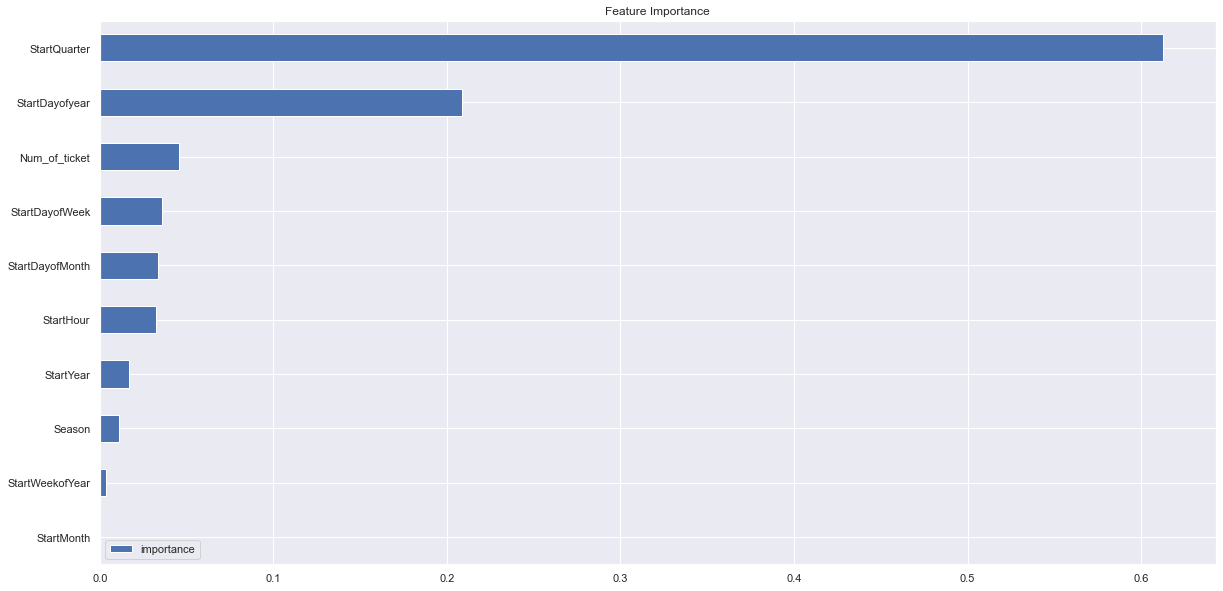

In [859]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

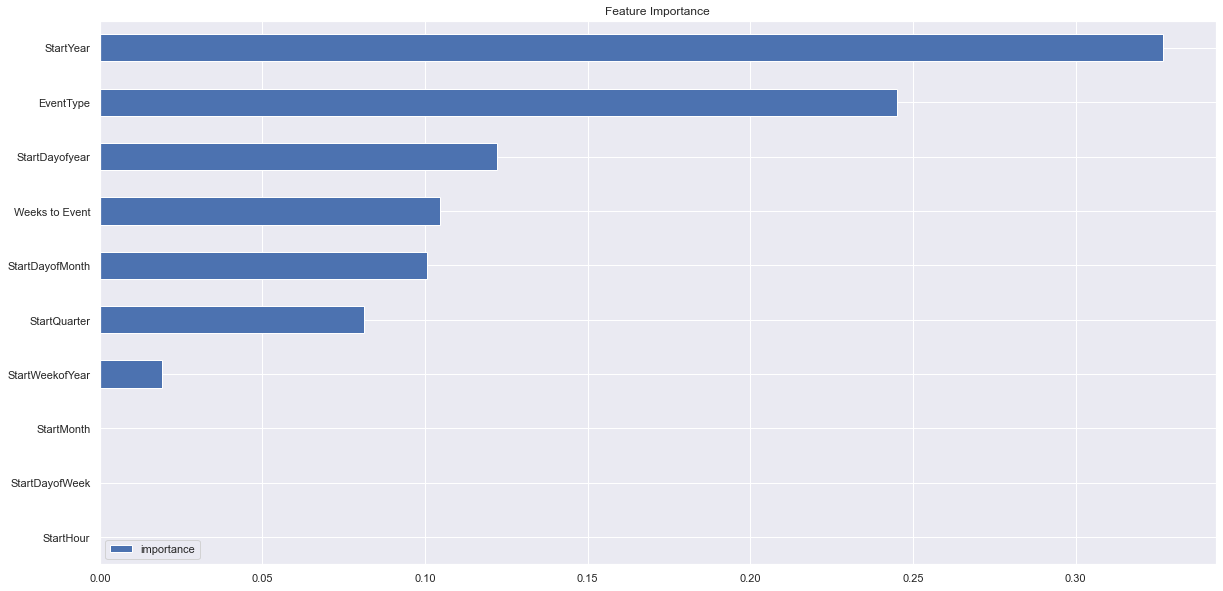

In [1183]:
fi1.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [860]:
test_week_purchase_period['XGB_Purchase_period'] = reg_week_purchase_period.predict(X_test_week_purchase_period)


In [1184]:
test_weekly_ticket_sales['XGB_NumofTicket'] = reg_weekly_ticket_sales.predict(X_test_weekly_ticket_sales)

### Storing Predictions

### Forcast on Test

In [ ]:
test_week_purchase_period['XGB_Purchase_period'] = reg_week_purchase_period.predict(X_test_week_purchase_period)
data_week_purchase_period = data_week_purchase_period.merge(test_week_purchase_period[['XGB_Purchase_period']], how='left', left_index=True, right_index=True)
ax = data_week_purchase_period[['XGB_Purchase_period']].plot(figsize=(15,5))
data_week_purchase_period['XGB_Purchase_period'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'XGB_Purchase_period'])
ax.set_title('Raw Purchase Period Data and Predictions')
plt.show()

In [ ]:
# test_weekly_ticket_sales['XGB_NumofTicket'] = reg_weekly_ticket_sales.predict(X_test_weekly_ticket_sales)
df1 = df1.merge(test_weekly_ticket_sales[['XGB_NumofTicket']], how='left', left_index=True, right_index=True)
ax = df1[['Num_of_ticket']].plot(figsize=(15,5))
test_weekly_ticket_sales['XGB_NumofTicket'].plot(legend=True)
plt.legend(['Num_of_Tickets', 'XGB_NumofTicket'])
ax.set_title("Raw Num of Tickets and Predicted Num of Tickets")
plt.show()

Text(0.5, 1.0, 'Purchase Period per Event - XGBoost')

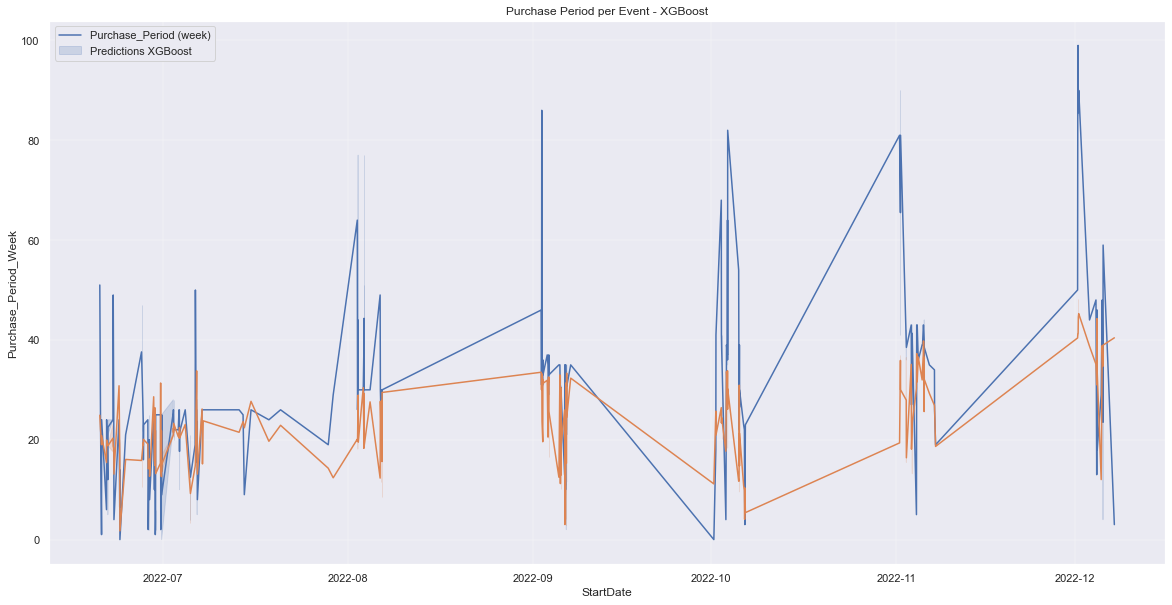

In [1147]:
sns.set(rc={'figure.figsize':(20,10)})
# data_week_purchase_period = data_week_purchase_period.merge(test_week_purchase_period[['XGB_Purchase_period']], how='left', left_index=True, right_index=True)
sns.lineplot(x = test_week_purchase_period['StartDate'], y = test_week_purchase_period['Purchase_Period_Week'],data= test_week_purchase_period)
sns.lineplot(x = test_week_purchase_period['StartDate'], y = test_week_purchase_period['XGB_Purchase_period'],data= test_week_purchase_period)

plt.grid(linestyle='-',linewidth=0.3)
plt.legend(labels=['Purchase_Period (week)','Predictions XGBoost'])
plt.title('Purchase Period per Event - XGBoost')
# plt.legend(labels=['Purchase_Period_Pred', 'Purchase_Period'])

In [1079]:
df2 = df1.merge(test_weekly_ticket_sales[['XGB_NumofTicket']], how='left', left_index=True, right_index=True)
df1

,Weeks to Event,StatusCreatedDate,Num_of_ticket,StartHour,StartDayofWeek,StartQuarter,StartDayofyear,StartMonth,StartYear,StartDayofMonth,StartWeekofYear,XGB_NumofTicket
0,0.0,2021-01-10,21,0,6,1,10,1,2021,10,1,NaN
1,0.0,2021-01-17,144,0,6,1,17,1,2021,17,2,NaN
2,0.0,2021-01-24,0,0,6,1,24,1,2021,24,3,NaN
3,0.0,2021-01-31,0,0,6,1,31,1,2021,31,4,NaN
4,0.0,2021-02-07,0,0,6,1,38,2,2021,7,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3461,94.0,2021-02-07,0,0,6,1,38,2,2021,7,5,2.740293
3462,94.0,2021-02-14,1,0,6,1,45,2,2021,14,6,6.007633
3463,98.0,2021-01-10,5,0,6,1,10,1,2021,10,1,2.964990
3464,98.0,2021-01-17,3,0,6,1,17,1,2021,17,2,6.140961


Text(0.5, 1.0, 'Raw Num of Tickets and Predicted Num of Tickets - XGBoost')

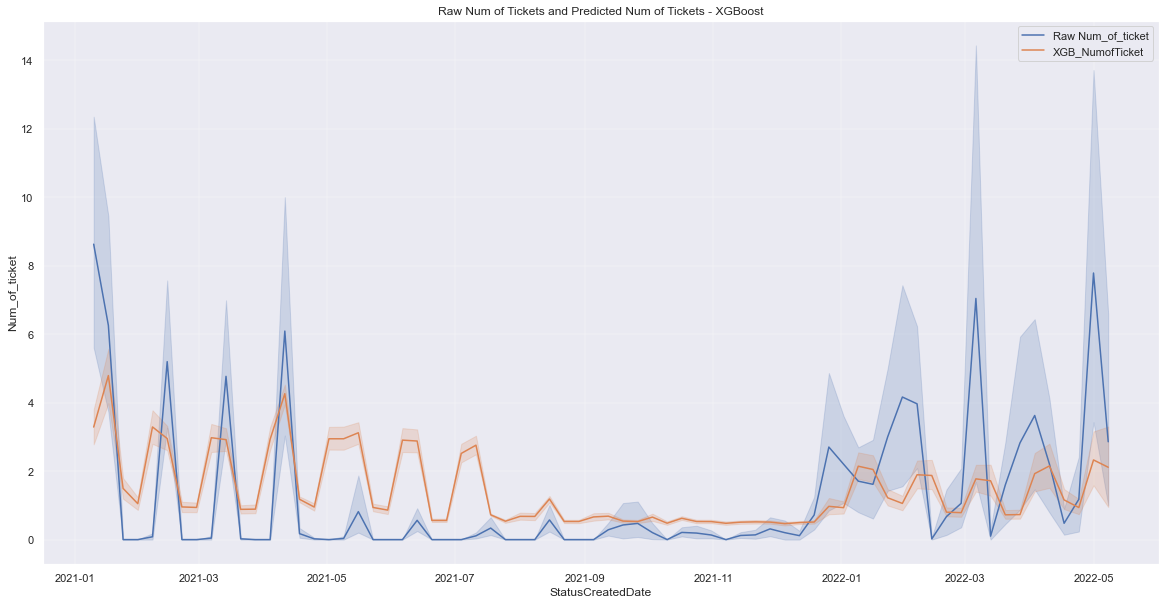

In [1185]:
# sns.set(rc={'figure.figsize':(20,10)})

ax = sns.lineplot(x = 'StatusCreatedDate', y = 'Num_of_ticket',data= test_weekly_ticket_sales, label="Raw Num_of_ticket")
ax2 = sns.lineplot(x = 'StatusCreatedDate', y = 'XGB_NumofTicket',data= test_weekly_ticket_sales, label="XGB_NumofTicket")

plt.grid(linestyle='-',linewidth=0.3)
plt.legend()
plt.title('Raw Num of Tickets and Predicted Num of Tickets - XGBoost')

Text(0.5, 1.0, 'Raw Num of Tickets and Predicted Num of Tickets (Weeks to Event) - XGBoost')

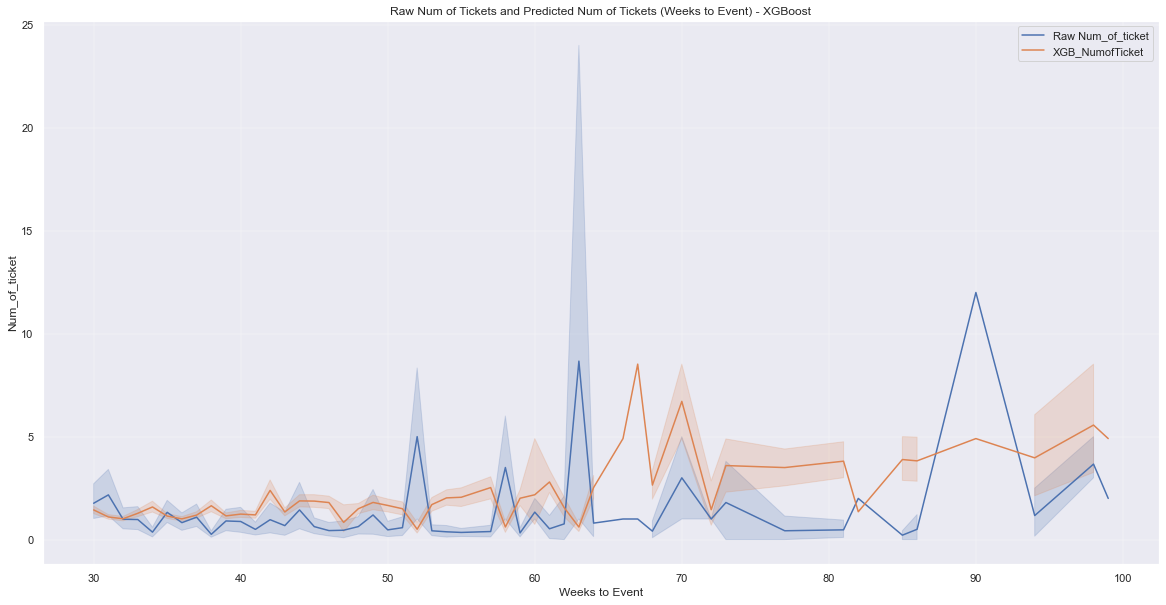

In [1186]:
ax = sns.lineplot(x = test_weekly_ticket_sales['Weeks to Event'], y = test_weekly_ticket_sales['Num_of_ticket'],data= test_weekly_ticket_sales, label="Raw Num_of_ticket")
ax2 = sns.lineplot(x = test_weekly_ticket_sales['Weeks to Event'], y = test_weekly_ticket_sales['XGB_NumofTicket'],data= test_weekly_ticket_sales, label="XGB_NumofTicket")

plt.grid(linestyle='-',linewidth=0.3)
plt.legend()
plt.title('Raw Num of Tickets and Predicted Num of Tickets (Weeks to Event) - XGBoost')

In [ ]:
data_week_purchase_period.set_index('StartDate')
test_week_purchase_period.set_index('StartDate')
ax = data_week_purchase_period[['Purchase_Period_Week']].plot(figsize=(15,5))
test_week_purchase_period['XGB_Purchase_period'].plot(legend=True)
plt.legend(['Truth Data', 'XGB_Purchase_period'])
ax.set_title('Raw Purchase Period Data and Predictions')
plt.show()